# Data Science Salaries EDA  - Pred. LGBMRegressor

### Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yusufdelikkaya/datascience-salaries-2024")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/yusufdelikkaya/datascience-salaries-2024/versions/1


In [2]:
!ls -l $path

total 832
-rw-r--r-- 1 root root 850882 Oct 25 22:46 DataScience_salaries_2024.csv


### Import dependencies

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
import seaborn as sns
import matplotlib.pyplot as plt

### Read Dataset

In [4]:
df = pd.read_csv(path + "/DataScience_salaries_2024.csv")

In [5]:
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L
1,2021,MI,FT,BI Data Analyst,11000000,HUF,36259,HU,50,US,L
2,2020,MI,FT,Data Scientist,11000000,HUF,35735,HU,50,HU,L
3,2021,MI,FT,ML Engineer,8500000,JPY,77364,JP,50,JP,S
4,2022,SE,FT,Lead Machine Learning Engineer,7500000,INR,95386,IN,50,IN,L


### Correlation Matrix

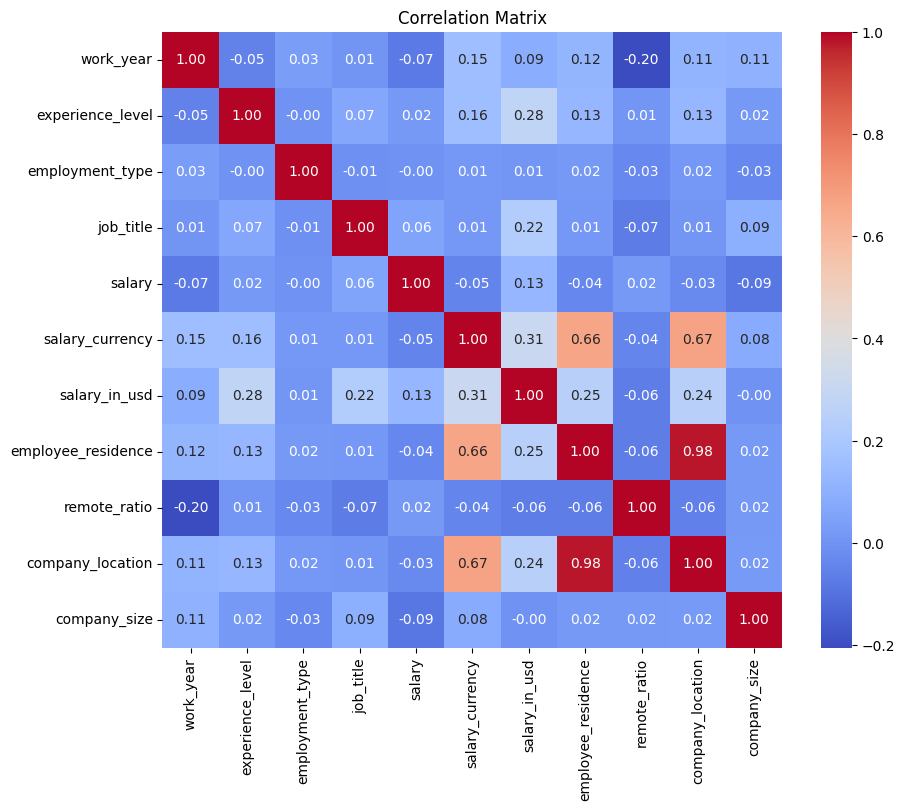

In [6]:
df_ds = df.copy()

columns_to_encode = ['experience_level', 'employment_type', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'company_size']

for column in columns_to_encode:
    le = LabelEncoder()
    df_ds[column] = le.fit_transform(df[column])

correlation = df_ds.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# EDA

### Comparison of Salary in USD by Experience Level

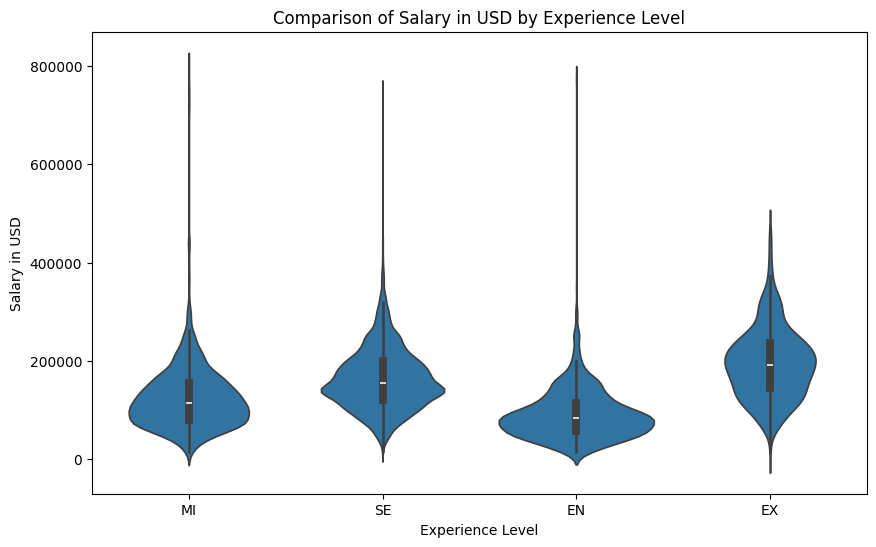

In [54]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='experience_level', y='salary_in_usd', data=df)
plt.xlabel('Experience Level')
plt.ylabel('Salary in USD')
plt.title('Comparison of Salary in USD by Experience Level')
plt.show()

### Max salary

In [55]:
max_salary_index = df['salary_in_usd'].idxmax()
max_salary_row = df.loc[max_salary_index]
print(max_salary_row)

work_year                     2024
experience_level                MI
employment_type                 FT
job_title             AI Architect
salary                      800000
salary_currency                USD
salary_in_usd               800000
employee_residence              CA
remote_ratio                   100
company_location                CA
company_size                     M
Name: 66, dtype: object


### Variation of Salary During the Years

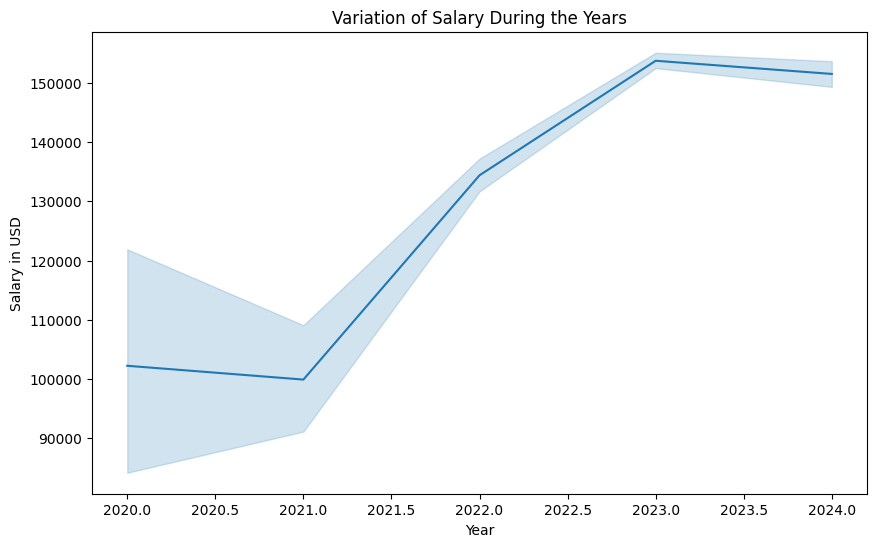

In [56]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='work_year', y='salary_in_usd', data=df)
plt.xlabel('Year')
plt.ylabel('Salary in USD')
plt.title('Variation of Salary During the Years')
plt.show()

### Correlation with salary

In [7]:
# Get the correlation of all columns with 'salary_in_usd'
correlation_with_salary = correlation['salary_in_usd'].sort_values(ascending=False)

# Display the most important columns (excluding 'salary_in_usd' itself)
most_important_columns = correlation_with_salary.drop('salary_in_usd')
print(most_important_columns)

salary_currency       0.312133
experience_level      0.275477
employee_residence    0.246008
company_location      0.243811
job_title             0.223732
salary                0.128313
work_year             0.090873
employment_type       0.010881
company_size         -0.004806
remote_ratio         -0.064829
Name: salary_in_usd, dtype: float64


## Model

In [15]:
X = df_ds.drop(['salary_in_usd'], axis=1)
y = df_ds['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LGBMRegressor(random_state=42, n_jobs=-1, n_estimators=1000)
# Fit the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 11870, number of used features: 10
[LightGBM] [Info] Start training from score 149326.521061


### Error mean

In [22]:
error = y_test - y_pred

error.mean()

-154.2556618642965

## Plotting

### KDEPlot

/tmp/ipykernel_221114/2848578879.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='y_test', color='blue', shade=True)
/tmp/ipykernel_221114/2848578879.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred, label='y_pred', color='red', shade=True)


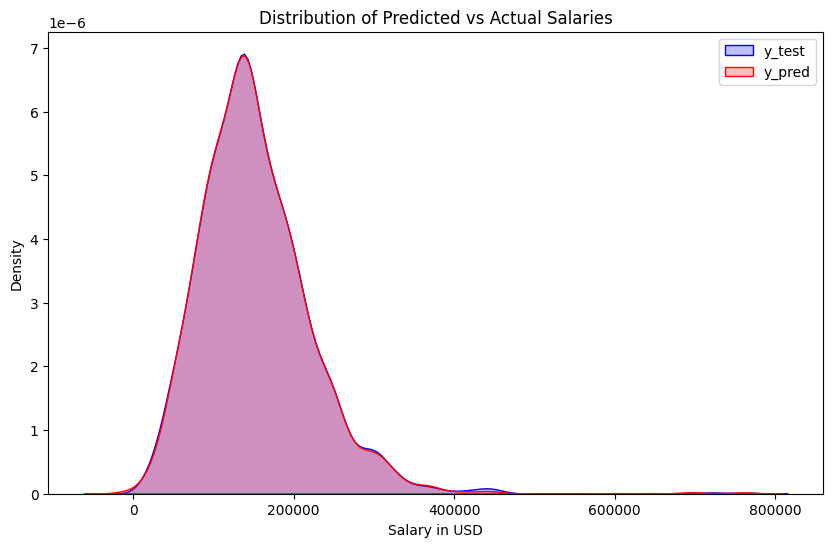

In [23]:
plt.figure(figsize=(10, 6))
sns.kdeplot(y_test, label='y_test', color='blue', shade=True)
sns.kdeplot(y_pred, label='y_pred', color='red', shade=True)
plt.xlabel('Salary in USD')
plt.ylabel('Density')
plt.title('Distribution of Predicted vs Actual Salaries')
plt.legend()
plt.show()

### Linear plot

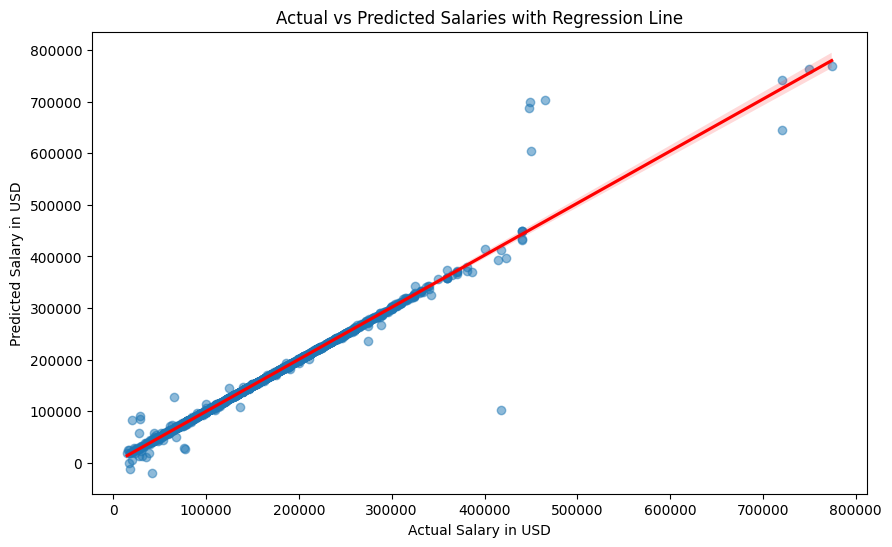

In [50]:
plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Actual Salary in USD')
plt.ylabel('Predicted Salary in USD')
plt.title('Actual vs Predicted Salaries with Regression Line')
plt.show()

### Bars plotting

<Figure size 2000x600 with 0 Axes>

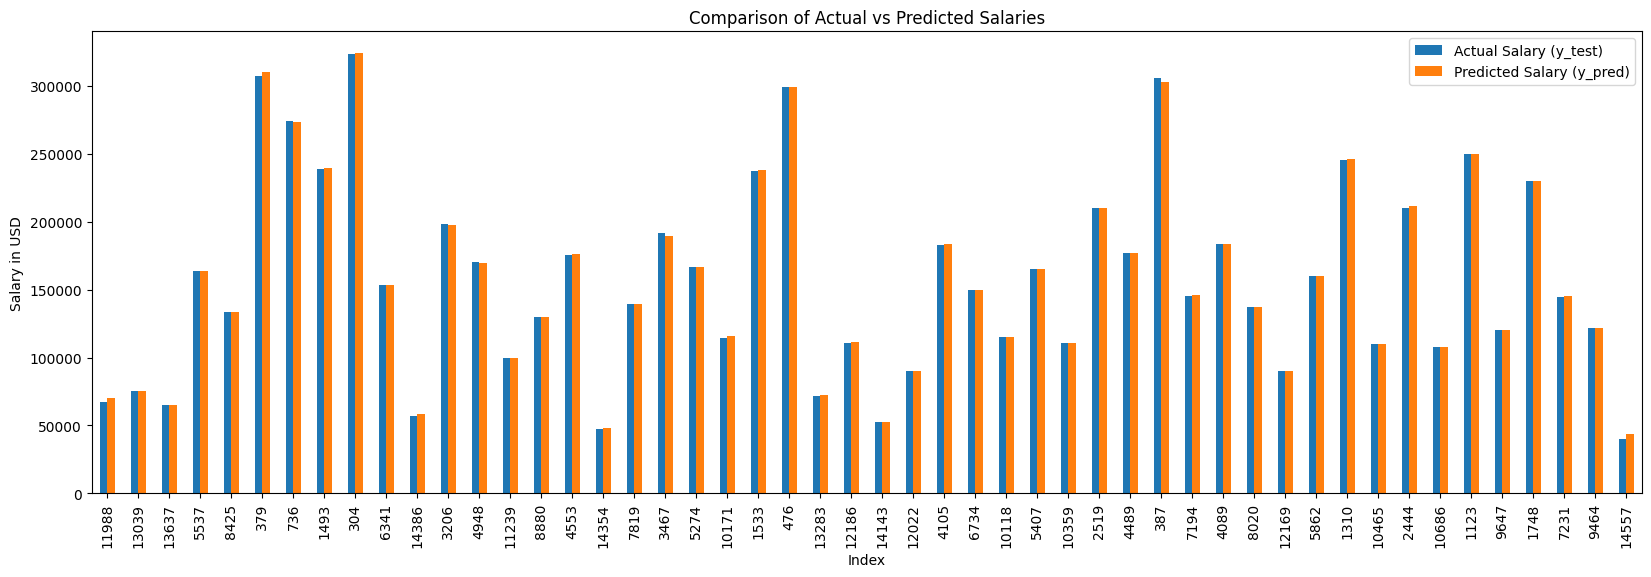

In [51]:
# Create a DataFrame for easier plotting
comparison_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Plot the comparison
plt.figure(figsize=(20, 6))
comparison_df.head(50).plot(kind='bar', figsize=(20, 6))
plt.xlabel('Index')
plt.ylabel('Salary in USD')
plt.title('Comparison of Actual vs Predicted Salaries')
plt.legend(['Actual Salary (y_test)', 'Predicted Salary (y_pred)'])
plt.show()

### Line Plotting

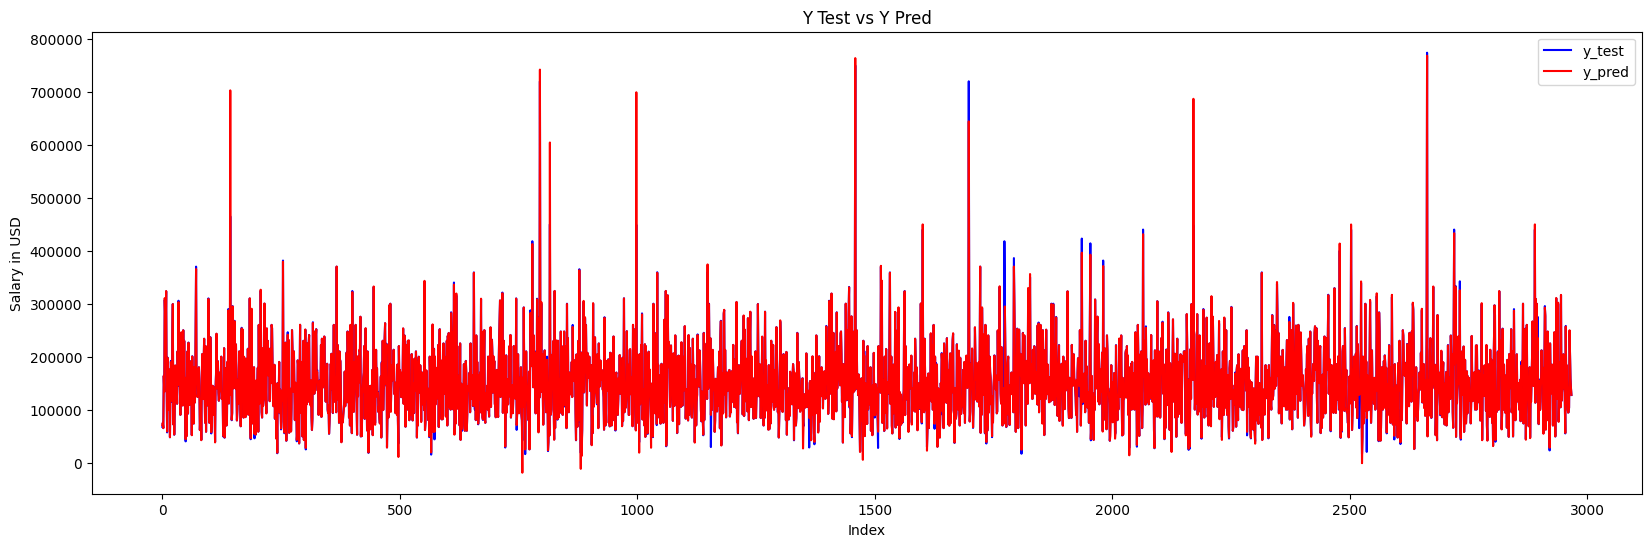

In [18]:
plt.figure(figsize=(20, 6))
sns.lineplot(x=range(len(y_test)), y=y_test, label='y_test', color='blue')
sns.lineplot(x=range(len(y_test)), y=y_pred, label='y_pred', color='red')
plt.xlabel('Index')
plt.ylabel('Salary in USD')
plt.title('Y Test vs Y Pred')
plt.legend()
plt.show()

### Conclusion

In this notebook, we explored the dataset of data science salaries for 2024, performing extensive exploratory data analysis (EDA) and building a predictive model using the LightGBM regressor. We visualized various aspects of the data, such as salary distribution by experience level and the variation of salaries over the years. Our model provided insights into the factors influencing salaries, with salary currency and experience level being the most significant predictors. The predictions were visualized and compared with actual values, highlighting the model's performance. This analysis offers valuable insights into the data science job market and salary trends.